In [34]:
#!/usr/bin/env python2
import os
import sys
import argparse
import time
from distutils.dir_util import copy_tree


import numpy as np
import random
import theano
import theano.tensor as T
from theano import config
import lasagne
from lasagne.regularization import regularize_network_params
from lasagne.objectives import binary_crossentropy

from iterator import Iterator
import autoencoder_model as ae_model

import PIL.Image as Image
from matplotlib import pyplot as plt
from matplotlib import colors
%matplotlib inline

In [2]:
#Training hyper-parameters

learning_rate = 0.01
weight_decay = 0
num_epochs = 500
max_patience = 100
#data_augmentation={}
SAVEPATH = 'save_models' 
LOADPATH = 'load_models'
batch_size = 512
extract_center = True
load_caption = False
#nb_discriminator_steps = 2

#Model Hyperparameters
conv_before_pool=[2,2,2]
n_filters = 32                      
code_size = 500


#n_units_dense_layer = 10
out_nonlin = lasagne.nonlinearities.sigmoid
_FLOATX = config.floatX


In [3]:
#######################
# Saving path and stuff
######################
exp_name = 'AE'

savepath=os.path.join(sys.path[1],SAVEPATH, exp_name)
loadpath=os.path.join(sys.path[1],LOADPATH, exp_name)

if not os.path.exists(savepath):
    os.makedirs(savepath)
else:
    print('\033[93m The following folder already exists {}. '
          'It will be overwritten in a few seconds...\033[0m'.format(
              savepath))
print 'Saving directory : ' + savepath
print 'Loading directory : '+ loadpath

 The following folder already exists /u/larocste/ift6266_project/save_models/AE. It will be overwritten in a few seconds...
Saving directory : /u/larocste/ift6266_project/save_models/AE
Loading directory : /u/larocste/ift6266_project/load_models/AE


In [41]:
#######################
#Build dataset iterator
#######################

print "Loading training data..." #threads???
train_iter = Iterator(which_set='train', batch_size = batch_size,
            extract_center = extract_center, load_caption = load_caption)

print "Loading validation data..." #threads???
valid_iter = Iterator(which_set='valid', batch_size = batch_size,
            extract_center = extract_center, load_caption = load_caption)

test_iter = None

n_batches_train = train_iter.n_batches
n_batches_valid = valid_iter.n_batches
n_batches_test = test_iter.n_batches if test_iter is not None else 0

print "Batch. train: %d, val %d, test %d" % (n_batches_train,
                            n_batches_valid, n_batches_test)

Loading training data...
Loading validation data...
Batch. train: 161, val 79, test 0


In [5]:
##########################################
# Build generator and discriminator models
##########################################
print('Defining symbolic variables and building models')

#Input and target var for the generator
ae_input_var = T.tensor4('input img bx3x32x32')
ae_target_var = T.tensor4('inpainting target')



print('Building AE model')
ae, last_layer = ae_model.AE_contour2center().build_network(input_var = ae_input_var,
                                              conv_before_pool=conv_before_pool,
                                              n_filters = n_filters,
                                              code_size = code_size)

Defining symbolic variables and building models
Building AE model


In [28]:
valid_input_var = T.tensor4('valid input var')
valid_target_var = T.tensor4('valid target var')

In [6]:
##########################################
# Build generator and discriminator models
##########################################



#Print layers and shape (to debug)
print 'AE layers'
for layer in lasagne.layers.get_all_layers(ae):
    print layer, ae[layer].output_shape


AE layers
conv0_0 (None, 32, 64, 64)
bn0_1 (None, 32, 64, 64)
last_layer (None, 3, 32, 32)
dense_up (None, 16384)
bn0_0 (None, 32, 64, 64)
upconv1_0 (None, 64, 32, 32)
bn1_0 (None, 64, 32, 32)
conv0_1 (None, 32, 64, 64)
reshape_enc (None, 16384)
upscale1 (None, 64, 32, 32)
upconv1_1 (None, 64, 32, 32)
bn1_1 (None, 64, 32, 32)
reshape_dec (None, 64, 16, 16)
code_dense (None, 500)
conv1_0 (None, 64, 32, 32)
conv1_1 (None, 64, 32, 32)
input (None, 3, 64, 64)
pool1 (None, 64, 16, 16)
pool0 (None, 32, 32, 32)


In [7]:
#####################################
# Define and compile theano functions
#####################################

print "Defining and compiling theano functions"
pred_img = lasagne.layers.get_output(ae[last_layer])

ae_loss = T.mean(lasagne.objectives.squared_error(pred_img, ae_target_var))
#TODO : weight decay
# if weight_decay > 0:
#     weightsl2 = regularize_network_params(
#         ae, lasagne.regularization.l2)
#     ae_loss += weight_decay * weightsl2


ae_params = lasagne.layers.get_all_params(ae[last_layer], trainable=True)
ae_updates = lasagne.updates.adam(ae_loss, ae_params, learning_rate = learning_rate)
#discr_acc = $dicriminator accuracy
ae_train_fn = theano.function([ae_input_var,ae_target_var], ae_loss, updates = ae_updates,
                            allow_input_downcast=True)

print 'Done'



Defining and compiling theano functions
Done


In [30]:
print "Defining and compiling valid functions"
valid_pred_imgs = lasagne.layers.get_output(ae[last_layer],deterministic=True)

valid_loss = T.mean(lasagne.objectives.squared_error(valid_pred_imgs, ae_target_var)) 



ae_valid_fn = theano.function([ae_input_var, ae_target_var], valid_loss, allow_input_downcast=True)

print "Done"

Defining and compiling valid functions
Done


In [8]:
get_imgs = theano.function([ae_input_var], lasagne.layers.get_output(ae[last_layer],deterministic = True),
                          allow_input_downcast=True)

In [10]:
# def show_true_fake(true_imgs, subset = 1):
#     for i in range(subset):
#         idx = np.random.randint(true_imgs.shape[0])
#         fake_imgs = get_imgs(true_imgs[idx:idx+1])
        
#         image = np.transpose(true_imgs[idx], (1,2,0))
#         fake_one = np.transpose(fake_imgs[0], (1,2,0))
#         plt.imshow(image)
#         plt.figure()
#         plt.imshow(fake_one)
#         plt.figure()
#         plt.show()



In [10]:
# def show_images(images, subset = 1, transpose=True):
#     for i in range(subset):
#         idx = np.random.randint(images.shape[0])
#         image = np.transpose(images[idx], (1,2,0))
#         plt.imshow(image)
#         plt.figure()
#         plt.show()
    

In [9]:
def show_true_fake(batch, subset = 1, title = ''):
    inputs, targets, caps = batch #inputs and targets already transposed
    
    for i in range(subset):
        idx = np.random.randint(inputs.shape[0])
        fake_imgs = get_imgs(inputs[idx:idx+1])
        
        target_img = np.transpose(targets[idx], (1,2,0))
        fake_one = np.transpose(fake_imgs[0], (1,2,0))
        
#         plt.imshow(contour)
        plt.title('Ground truth vs predicted '+ title)
        plt.imshow(target_img)
        plt.figure()
        plt.imshow(fake_one)
        plt.figure()
        plt.show()



In [10]:
inputs_train, targets_train, caps_train = train_iter[:500]
        
inputs_train = np.transpose(inputs_train,(0,3,1,2))
targets_train = np.transpose(targets_train, (0,3,1,2))
batch_train = inputs_train, targets_train, caps_train

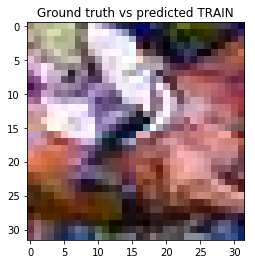

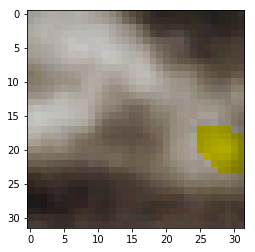

cost at epoch  0  =  0.023767799139
--------------------------------------------


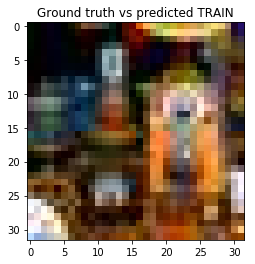

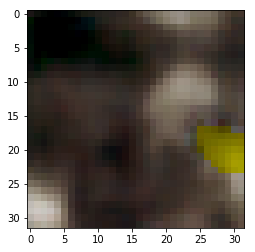

cost at epoch  1  =  0.0240059122443
--------------------------------------------


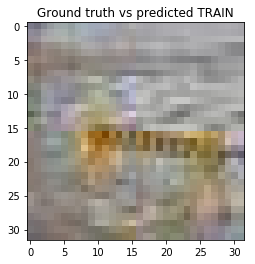

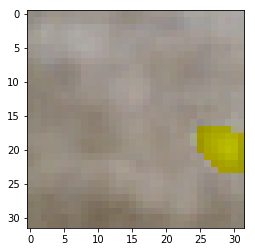

cost at epoch  2  =  0.0244816988707
--------------------------------------------


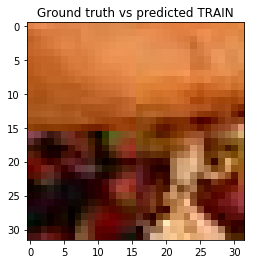

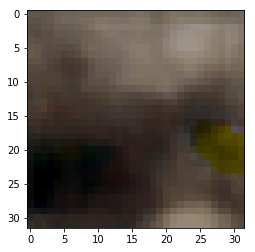

cost at epoch  3  =  0.0242858380079
--------------------------------------------


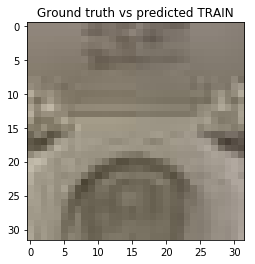

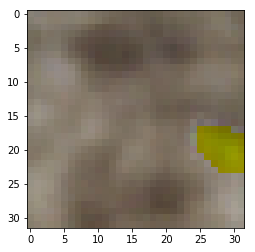

cost at epoch  4  =  0.023851595819
--------------------------------------------


In [19]:
num_epochs = 5
for ep in range(num_epochs):
    cost_epoch = 0
    for i in range(1):#, batch in enumerate(train_iter):

        #inputs, targets, caps = batch
        
        
        
        cost_minibatch = ae_train_fn(inputs_train, targets_train)
        #print "     minibatch ", i, " cost : ", cost_minibatch
        cost_epoch += cost_minibatch
        if num_epochs<=5:
             show_true_fake(batch_train, title = 'TRAIN')
        
    print 'cost at epoch ', ep, ' = ', cost_epoch
    
    

    print '--------------------------------------------'
            

In [20]:
inputs_valid, targets_valid, caps_valid = valid_iter[:500]
        
inputs_valid = np.transpose(inputs_valid,(0,3,1,2))
targets_valid= np.transpose(targets_valid, (0,3,1,2))
batch_valid = inputs_valid, targets_valid, caps_valid

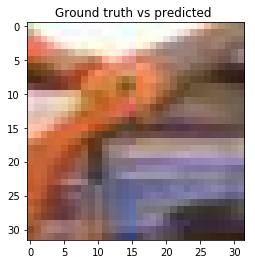

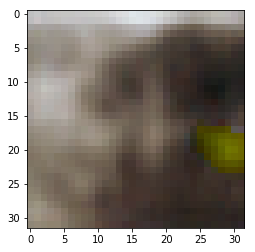

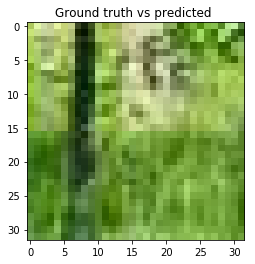

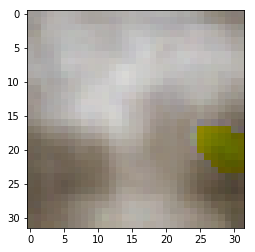

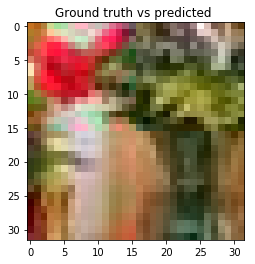

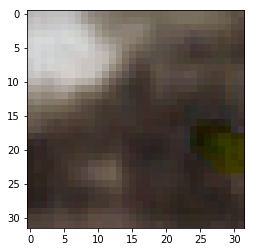

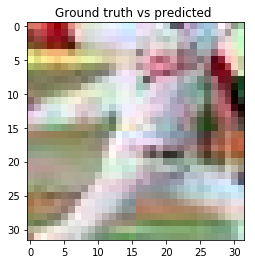

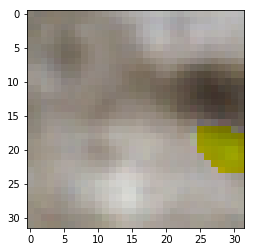

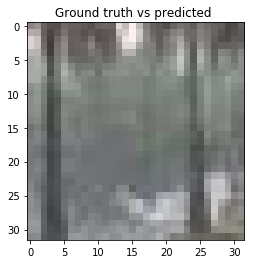

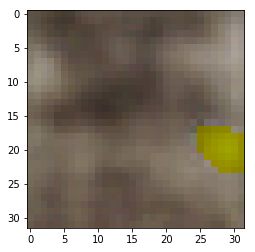

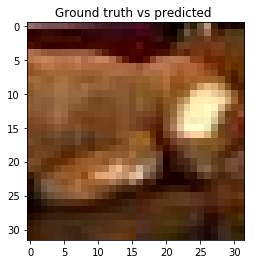

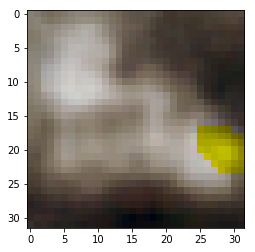

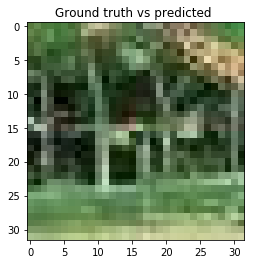

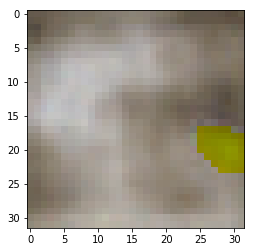

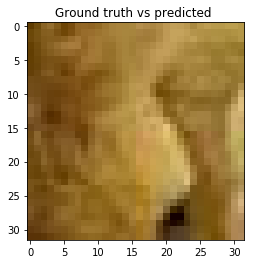

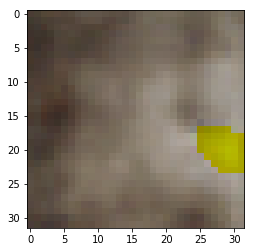

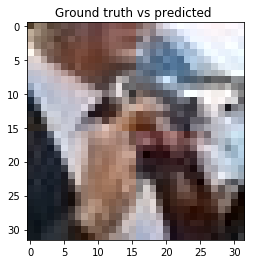

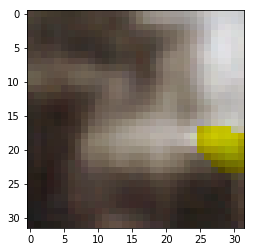

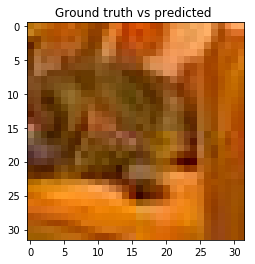

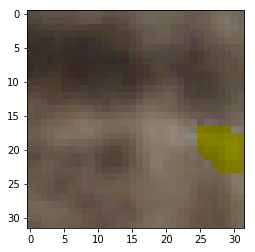

In [21]:
show_true_fake(batch_valid, subset = 10)

In [ ]:
#inpainting_valid = get_imgs(inputs_valid)

In [25]:
def extract_stuff(batch):
    inputs, targets, caps = batch
    inputs = np.transpose(inputs, (0,3,1,2))
    targets = np.transpose(targets, (0,3,1,2))
    
    return inputs, targets, caps

In [39]:
plot_results_train = False
plot_results_valid = False


num_epochs = 5
n_batches_train = 5
n_batches_valid = 5

In [40]:
#
# Train loop
#
err_train = []
sample_acc_train_tot = []

err_valid = []
sample_acc_valid_tot = []

#best_err_val = 0
patience = 0


# Training main loop
print "Start training"

for epoch in range(num_epochs):
    #learn_step.set_value((learn_step.get_value()*0.99).astype(theano.config.floatX))
    
    start_time = time.time()
    cost_train_epoch = 0
    
    # Train      
        
    for i, train_batch in enumerate(train_iter):
        if n_batches_train > 0 and i> n_batches_train:
            break
        
        inputs_train, targets_train, caps_train = extract_stuff(train_batch)   
        
        cost_train_batch = cost_minibatch = ae_train_fn(inputs_train, targets_train)
        
        print i, 'training batch cost : ', cost_train_batch

        #Update epoch results    
        cost_train_epoch += cost_train_batch
        
    #Add epoch results    
    err_train += [cost_train_epoch/n_batches_train]
    
    if plot_results_train: #select random example from the last minibatch and plot it
        show_true_fake(train_batch, title = 'TRAIN')

    # Validation
    cost_val_epoch = 0
    

    for i, valid_batch in enumerate(valid_iter):
        
        if n_batches_valid > 0 and i> n_batches_valid:
            break

        inputs_valid, targets_valid, caps_valid = extract_stuff(valid_batch)

        # Validation step
        cost_val_batch = ae_valid_fn(inputs_valid, targets_valid)
        print i, 'validation batch cost : ', cost_val_batch


        #Update epoch results
        cost_val_epoch += cost_val_batch
        
    
    if plot_results_valid: #select random example from the last minibatch and plot it
        show_true_fake(valid_batch, title = 'VALID')
        
    #Add epoch results 
    err_valid += [cost_val_epoch/n_batches_valid]
    

    #Print results (once per epoch)
    out_str = "EPOCH %i: Avg cost train %f, cost val %f, took %f s"
    out_str = out_str % (epoch, err_train[epoch],
                         #acc_train[epoch],
                         err_valid[epoch],
                         #acc_valid[epoch],
                         time.time()-start_time)
    print out_str
   
    

    # Early stopping and saving stuff
    
    with open(os.path.join(savepath, "ae_output.log"), "a") as f:
        f.write(out_str + "\n")
        
    if epoch == 0:
        best_err_valid = err_valid[epoch]
    elif epoch > 1 and err_valid[epoch] < best_err_valid:
        print('saving best (and last) model')
        best_err_valid = err_valid[epoch]
        patience = 0
        np.savez(os.path.join(savepath, 'ae_model_best.npz'),
                 *lasagne.layers.get_all_param_values(ae[last_layer]))
        np.savez(os.path.join(savepath , "ae_errors_best.npz"),
                 err_train=err_train, err_valid=err_valid)
        np.savez(os.path.join(savepath, 'ae_model_last.npz'),
                 *lasagne.layers.get_all_param_values(ae[last_layer]))
        np.savez(os.path.join(savepath , "ae_errors_last.npz"),
                 err_train=err_train, err_valid=err_valid)
    else:
        patience += 1
        print('saving last model')
        np.savez(os.path.join(savepath, 'ae_model_last.npz'),
                 *lasagne.layers.get_all_param_values(ae[last_layer]))
        np.savez(os.path.join(savepath , "ae_errors_last.npz"),
                 err_train=err_train, err_valid=err_valid)
        
    # Finish training if patience has expired or max nber of epochs reached
    if patience == max_patience or epoch == num_epochs-1:
        if savepath != loadpath:
            print('Copying model and other training files to {}'.format(loadpath))
            copy_tree(savepath, loadpath)
        break 




Start training
0 training batch cost :  0.0267107319087
1 training batch cost :  0.0407944321632
2 training batch cost :  0.0485994704068
3 training batch cost :  0.047032058239
4 training batch cost :  0.0473542548716
5 training batch cost :  0.0473010279238
0 validation batch cost :  0.0954648628831
1 validation batch cost :  0.0948719456792
2 validation batch cost :  0.0993563830853
3 validation batch cost :  0.0957206711173
4 validation batch cost :  0.100037932396
5 validation batch cost :  0.0985937640071
EPOCH 0: Avg cost train 0.051558, cost val 0.116809, took 23.737237 s
0 training batch cost :  0.0346258990467
1 training batch cost :  0.0424216277897
2 training batch cost :  0.043613165617
3 training batch cost :  0.04515536502
4 training batch cost :  0.0460140667856
5 training batch cost :  0.0459710769355
0 validation batch cost :  0.0482820309699
1 validation batch cost :  0.0469331294298
2 validation batch cost :  0.051320746541
3 validation batch cost :  0.0482606031001

cost 0  =  0.00409850804135


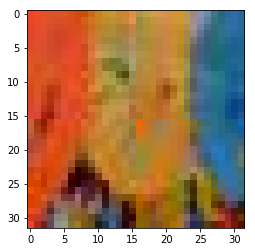

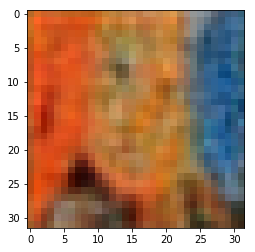

--------------------------------------------
cost 1  =  0.00411602994427


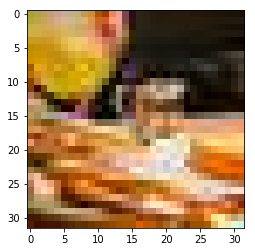

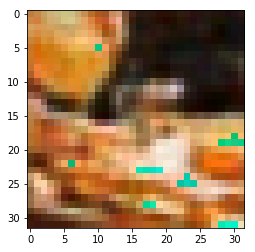

--------------------------------------------
cost 2  =  0.00415697321296


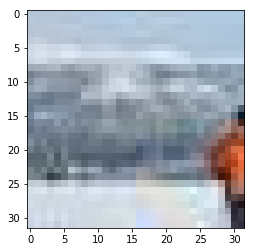

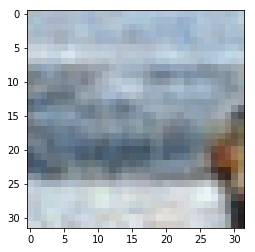

--------------------------------------------
cost 3  =  0.00425629178062


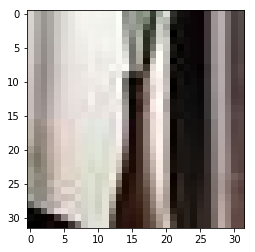

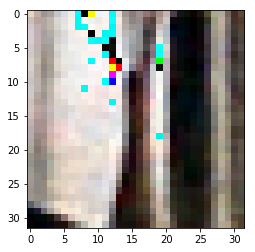

--------------------------------------------
cost 4  =  0.00424823211506


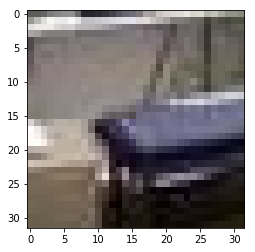

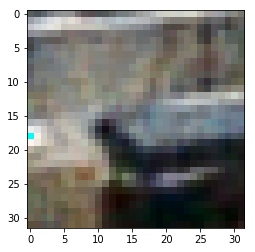

--------------------------------------------
cost 5  =  0.00426181172952


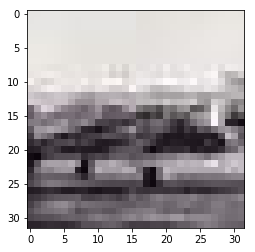

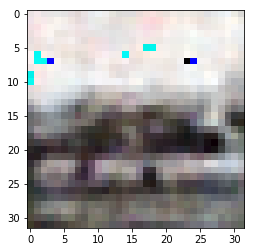

--------------------------------------------
cost 6  =  0.00412066606805


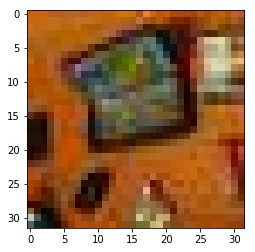

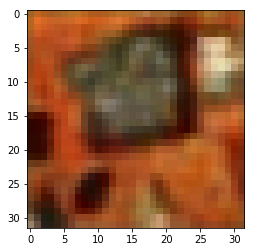

--------------------------------------------
cost 7  =  0.00401569716632


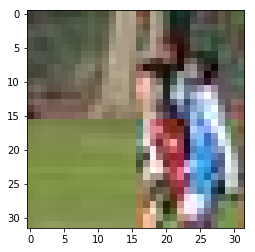

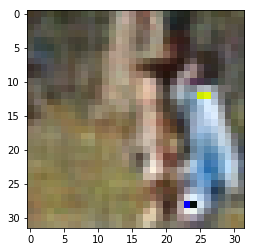

--------------------------------------------
cost 8  =  0.00393821625039


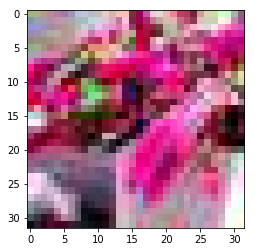

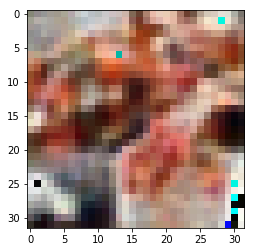

--------------------------------------------
cost 9  =  0.00390378409065


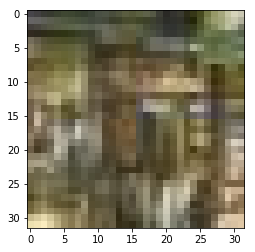

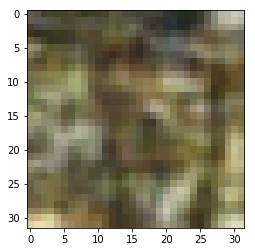

--------------------------------------------


In [21]:
num_epochs = 10
for i in range(num_epochs):
    
    cost = ae_train_fn(center_train_batch)
    print 'cost', i, ' = ', cost
    
    if num_epochs<=10:
        show_true_fake(center_train_batch)

    print '--------------------------------------------'
            